In [1]:
!pip install keras

In [1]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3))

In [3]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [4]:
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,111,242 (57.64 MB)

 Trainable params: 15,111,242 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Print the shapes of the datasets
print("******************")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


******************
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [6]:
y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

In [7]:
# Data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

print("******************")
print(X_train.shape)
print(y_train_ohe.shape)
print(X_test.shape)
print(y_test_ohe.shape)

******************
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [8]:
X_val = X_train[40000:]
y_val = y_train_ohe[40000:]
print(X_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 10)


In [11]:
sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Assuming `model` is already defined and compiled as follows:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Initialize the number of epochs and batch size
EPOCHS = 5
BS = 128

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")

# Ensure `X_train`, `y_train_ohe`, `X_val`, and `y_val` are your training and validation data
# Example:
# X_train = np.random.rand(1000, 224, 224, 3)  # replace with your actual data
# y_train = np.random.randint(10, size=(1000, 1))  # replace with your actual labels
# y_train_ohe = to_categorical(y_train, num_classes=10)  # one-hot encode your labels
# X_val = np.random.rand(200, 224, 224, 3)  # replace with your actual validation data
# y_val = to_categorical(np.random.randint(10, size=(200, 1)), num_classes=10)  # validation labels

# Train the model
history = model.fit(
    aug.flow(X_train, y_train_ohe, batch_size=BS),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS
)

Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1387s 4s/step - accuracy: 0.5914 - loss: 1.1797 - val_accuracy: 0.6810 - val_loss: 0.9290
Epoch 2/5
  1/390 ━━━━━━━━━━━━━━━━━━━━ 14:57 2s/step - accuracy: 0.6719 - loss: 0.9569

C:\Users\mouni\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


390/390 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.6719 - loss: 0.4797 - val_accuracy: 0.6845 - val_loss: 0.9125
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 2316s 6s/step - accuracy: 0.6744 - loss: 0.9603 - val_accuracy: 0.7737 - val_loss: 0.6516
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 208s 514ms/step - accuracy: 0.6484 - loss: 0.4834 - val_accuracy: 0.7658 - val_loss: 0.6738
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1780s 5s/step - accuracy: 0.7145 - loss: 0.8587 - val_accuracy: 0.7863 - val_loss: 0.6100


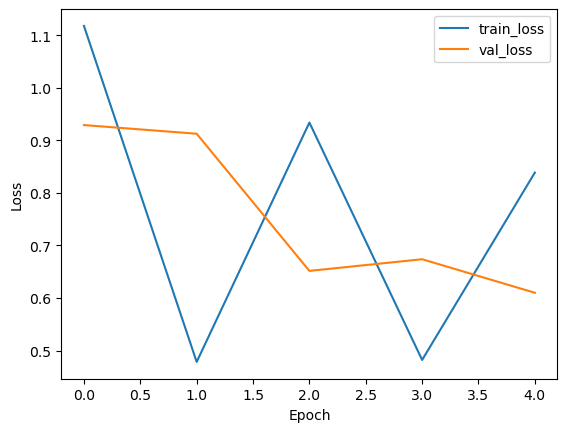

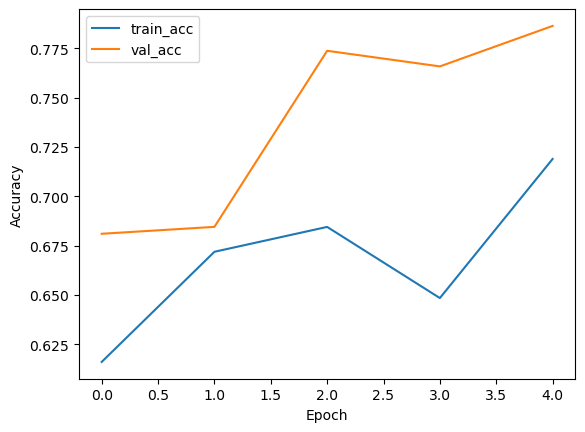

In [12]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
score = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.655463695526123
Test accuracy: 0.7760000228881836
